In [1]:
# # #@title Install dependencies and setup SplineCAM

# # !pip install --upgrade gdown
# # !git clone https://github.com/AhmedImtiazPrio/splinecam.git

# # !echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
# # !apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25

# # !echo "deb http://cz.archive.ubuntu.com/ubuntu bionic main universe" >> /etc/apt/sources.list
# # !apt-get update
# # !apt-get install python3-graph-tool python3-matplotlib python3-cairo

# # #python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
# # !apt purge python3-cairo
# # !apt install libcairo2-dev pkg-config python3-dev
# # !pip install --force-reinstall pycairo
# # !pip install zstandard
# # !pip install networkx
# # !pip install python-igraph>=0.10
# # !pip install tqdm
# # !pip install livelossplot

# # !pip uninstall torch torchvision -y
# # !pip install --pre torch==1.12+cu116 torchvision -f https://download.pytorch.org/whl/torch_stable.html

# # !pip install imageio-ffmpeg
# !mkdir animation

In [2]:
#@title Hepler Functions and Imports

import sys
sys.path.append('..')

import splinecam as splinecam
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch

import time
from livelossplot import PlotLosses
import copy
import tqdm

def make_dataloader(generator,n,
                 noise=0.05,seed=0,
                 batch_size=128):
    
    X,y = generator(n_samples=n,
                        shuffle=False,
                        noise=noise,
                        random_state=seed)
    
    inputs = torch.hstack([
        torch.Tensor(X),torch.Tensor(y[...,None])
    ])
    
    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader

/home/ah73/anaconda3/envs/envi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(-2.103231430053711, 2.6145594120025635)

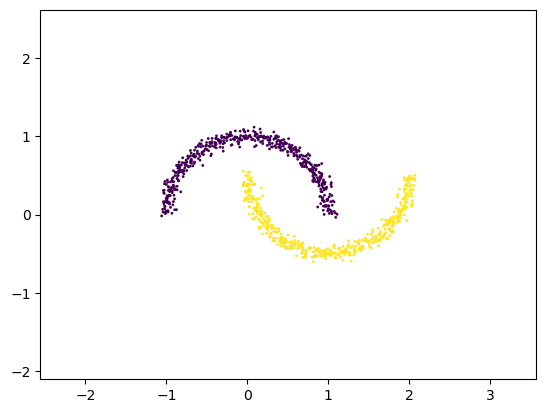

In [3]:
#@title Prepare Data and Specify Input Domain

# prepare data

from sklearn.datasets import make_moons, make_circles, make_blobs

dataloader = make_dataloader(make_moons,1000)

# get upper and lower bounds
xlow,ylow = dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

# ROI square domain at the input space
pad = 1.5
domain = torch.tensor([
    [xlow,ylow],
    [xlow,yhigh],
    [xhigh,yhigh],
    [xhigh,ylow],
    [xlow,ylow]
])

domain += np.sign(domain)*1.5

# Get projection matrix for 2D<->input
T = torch.eye(3)[:-1]

## plot data and set domain boundaries
plt.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
            dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
            c = dataloader.__dict__['dataset'][:,-1].numpy(),s=1,
           )
plt.xlim([domain[0][0],domain[2][0]])
plt.ylim([domain[0][1],domain[2][1]])

In [4]:
#@title Specify Network

width = 10
depth = 5

model = nn.Sequential(
    nn.Linear(2,width),
    nn.ReLU(),
    *[nn.Linear(width,width), nn.ReLU()]*(depth-2),
    nn.Linear(width,1),
)

model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=1, bias=True)
)

Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.07it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.47it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.13it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 456.80it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 608.78it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 816.41it/s]

iterating hyps: 100%|██████████

Current layer 3



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.38it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 55.41it/s]

Time elapsed 0.066 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 1908.90it/s]


Epoch: 1, Loss: 0.6922369748353958
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.33it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.75it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 661.94it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 898.91it/s]

iterating hyps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1222.29it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 685.01it/s]

iterating hyps: 100%|██████████

Current layer 3



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 415.40it/s]

Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.07it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.19it/s]

Time elapsed 0.058 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:00<00:00, 2177.03it/s]


Epoch: 2, Loss: 0.6864185705780983
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.92it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.88it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 794.71it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 439.95it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 457.53it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 441.95it/s]

iterating hyps: 100%|██████████

Current layer 3



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 575.39it/s]

Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 49.28it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 51.96it/s]

Time elapsed 0.063 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 1938.57it/s]


Epoch: 3, Loss: 0.6797821596264839
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.59it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.92it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 866.41it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 670.82it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 947.87it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 725.37it/s]

iterating hyps: 100%|██████████

Current layer 3



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 50.13it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 52.92it/s]

Time elapsed 0.060 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 1953.01it/s]


Epoch: 4, Loss: 0.672011211514473
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.01it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.09it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 876.92it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 585.55it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 683.00it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 752.68it/s]

iterating hyps: 100%|██████████

Current layer 3



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.80it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.50it/s]

Time elapsed 0.060 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1947.64it/s]


Epoch: 5, Loss: 0.6629007756710052
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 17.26it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 667.03it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 715.87it/s]

iterating hyps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1240.09it/s]

Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.77it/s]

Current layer 3



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.97it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 51.85it/s]

Time elapsed 0.058 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1946.52it/s]


Epoch: 6, Loss: 0.6524085104465485
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.57it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 609.02it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 988.52it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 944.77it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 908.45it/s]

iterating hyps: 100%|██████████

Current layer 3



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 40.05it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 58.01it/s]

Time elapsed 0.064 minutes


no intersections


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 708.56it/s]


Epoch: 7, Loss: 0.6407078504562378
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.42it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.44it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 598.25it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 474.40it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 413.21it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 462.62it/s]

Get Abw: 100%|█████████████████

Current layer 3



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 38.40it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 50.39it/s]

Time elapsed 0.064 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 1893.76it/s]


Epoch: 8, Loss: 0.6282728835940361
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.78it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.66it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 584.46it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 581.03it/s]

iterating hyps: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1807.11it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 721.10it/s]

iterating hyps: 100%|██████████

Current layer 3



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 604.80it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 867.07it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 682.41it/s]

Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 43.50it/s]

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 51.72it/s]

Time elapsed 0.065 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:00<00:00, 1806.88it/s]


Epoch: 9, Loss: 0.6153969913721085
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.98it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.97it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 603.09it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 462.00it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 652.81it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 738.95it/s]

Get Abw: 100%|█████████████████

Current layer 3



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 460.34it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 630.11it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 903.56it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 634.68it/s]

iterating hyps: 100%|██████████

Current layer 4



Get Abw: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 69.02it/s]

Time elapsed 0.066 minutes


no intersections


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 1932.86it/s]


Epoch: 10, Loss: 0.6021537259221077
Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.22it/s]

Finding regions from first layer graph



Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.22it/s]

Current layer 2



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 619.06it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 622.12it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 991.75it/s]

Get Abw: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.51it/s]

Current layer 3



iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 420.52it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 614.34it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 459.58it/s]

iterating hyps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 642.61it/s]

Iterating regions:  69%|███████

KeyboardInterrupt: 

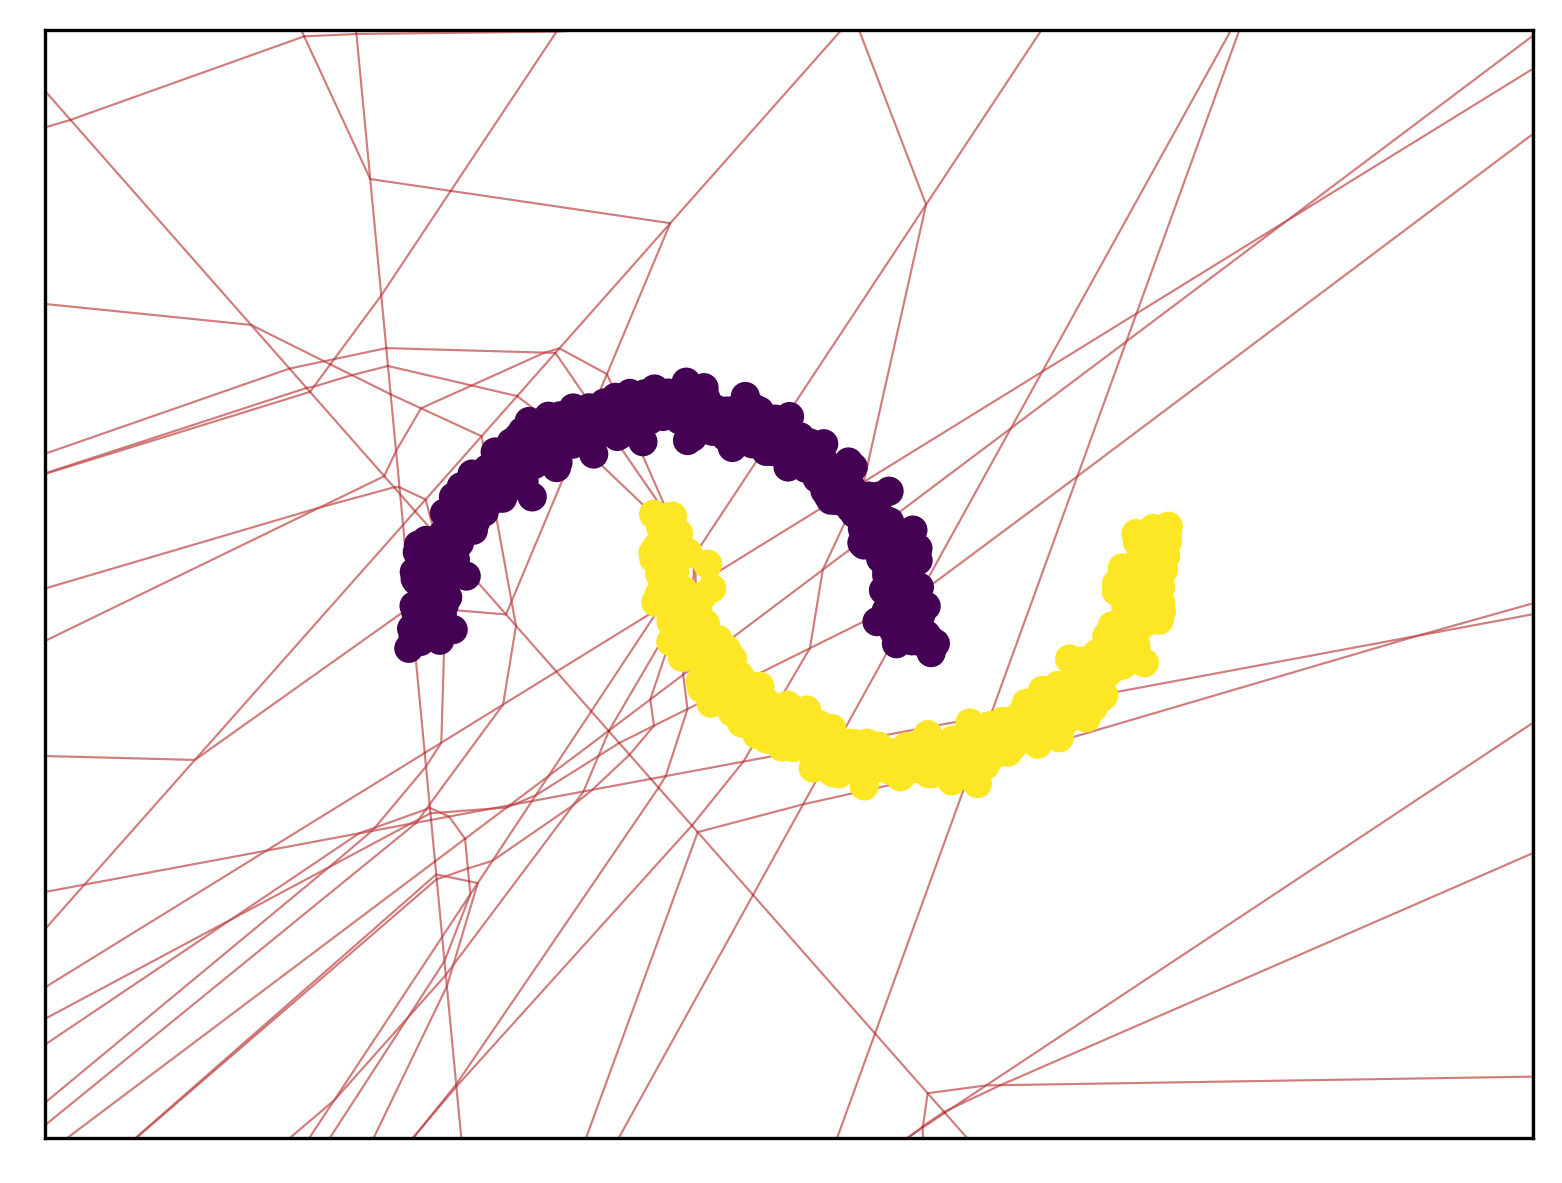

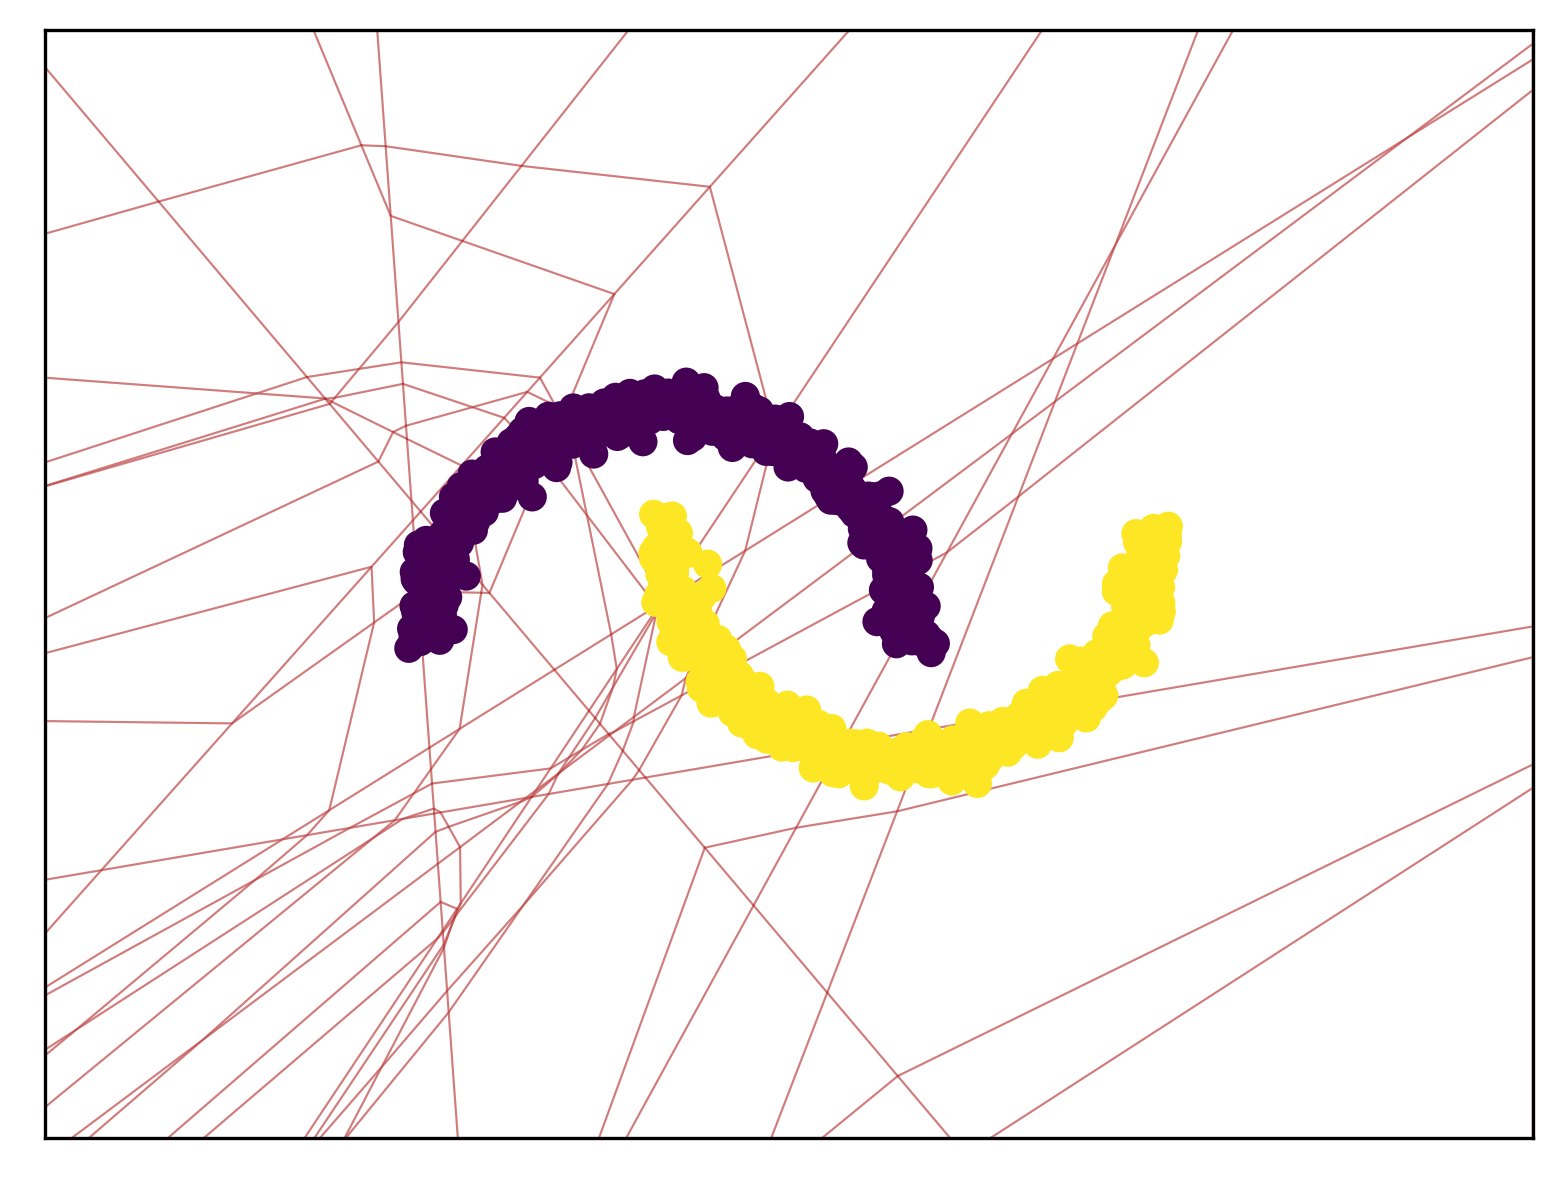

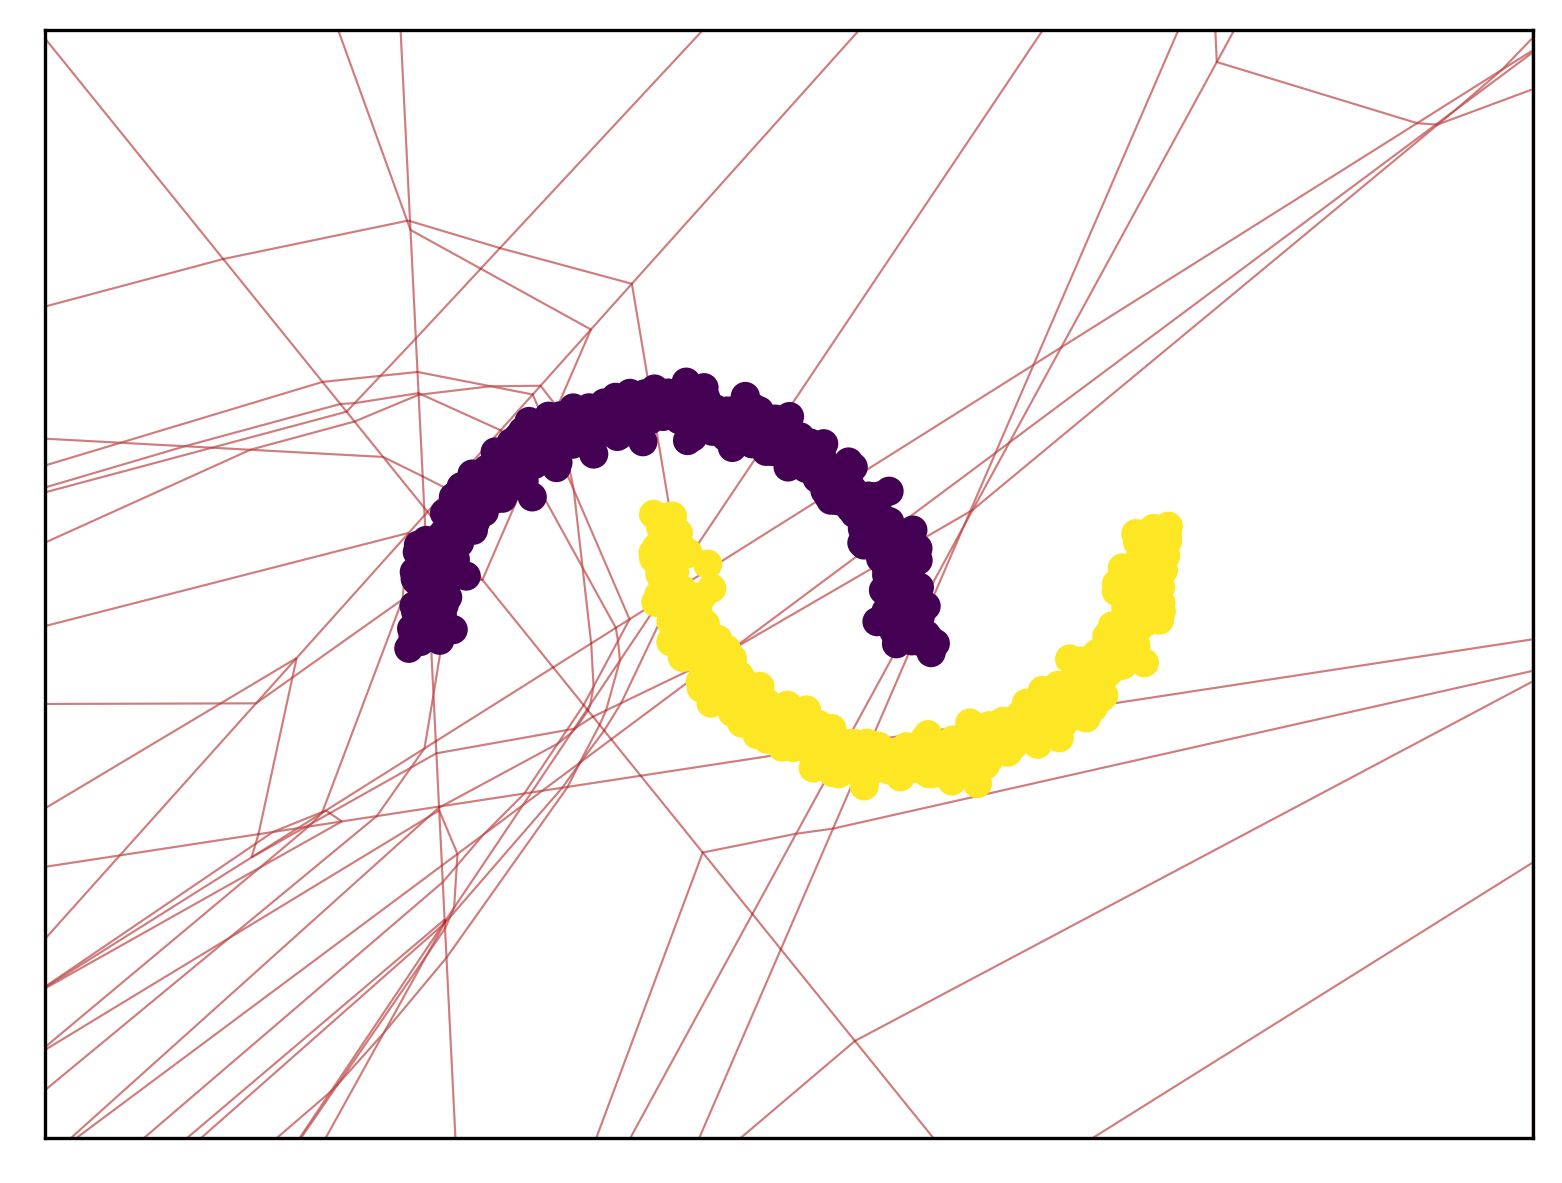

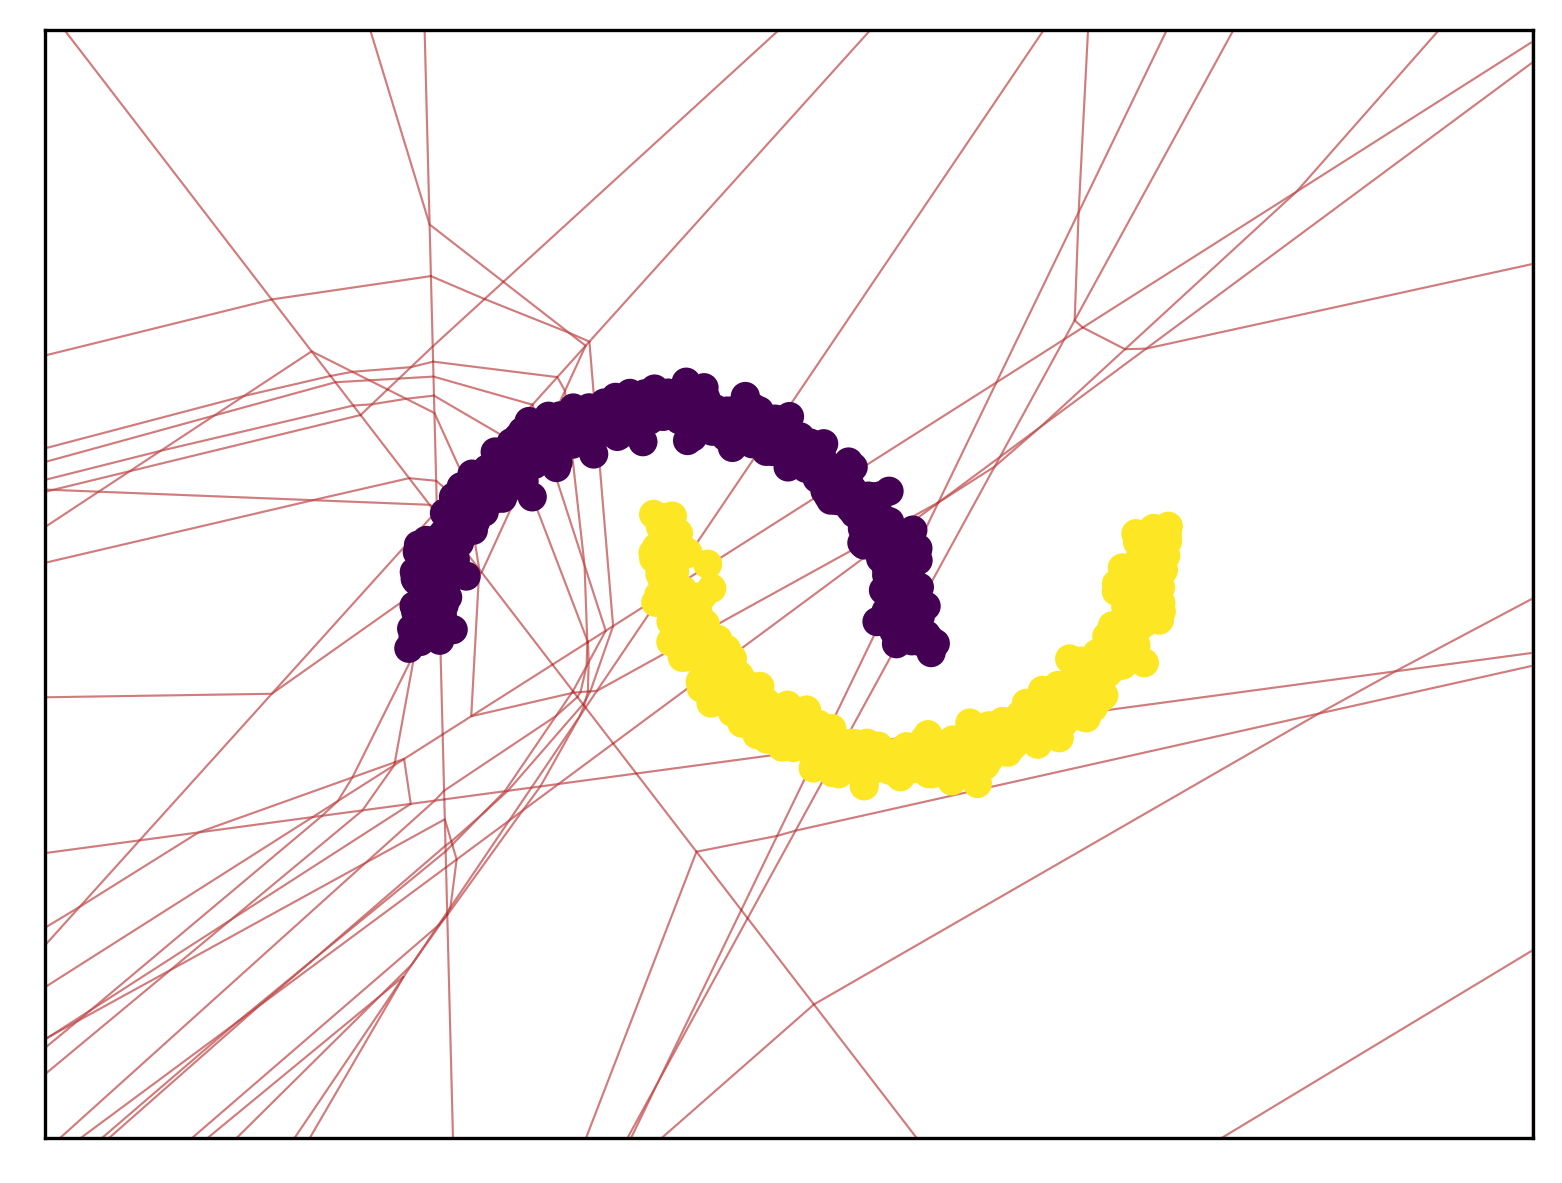

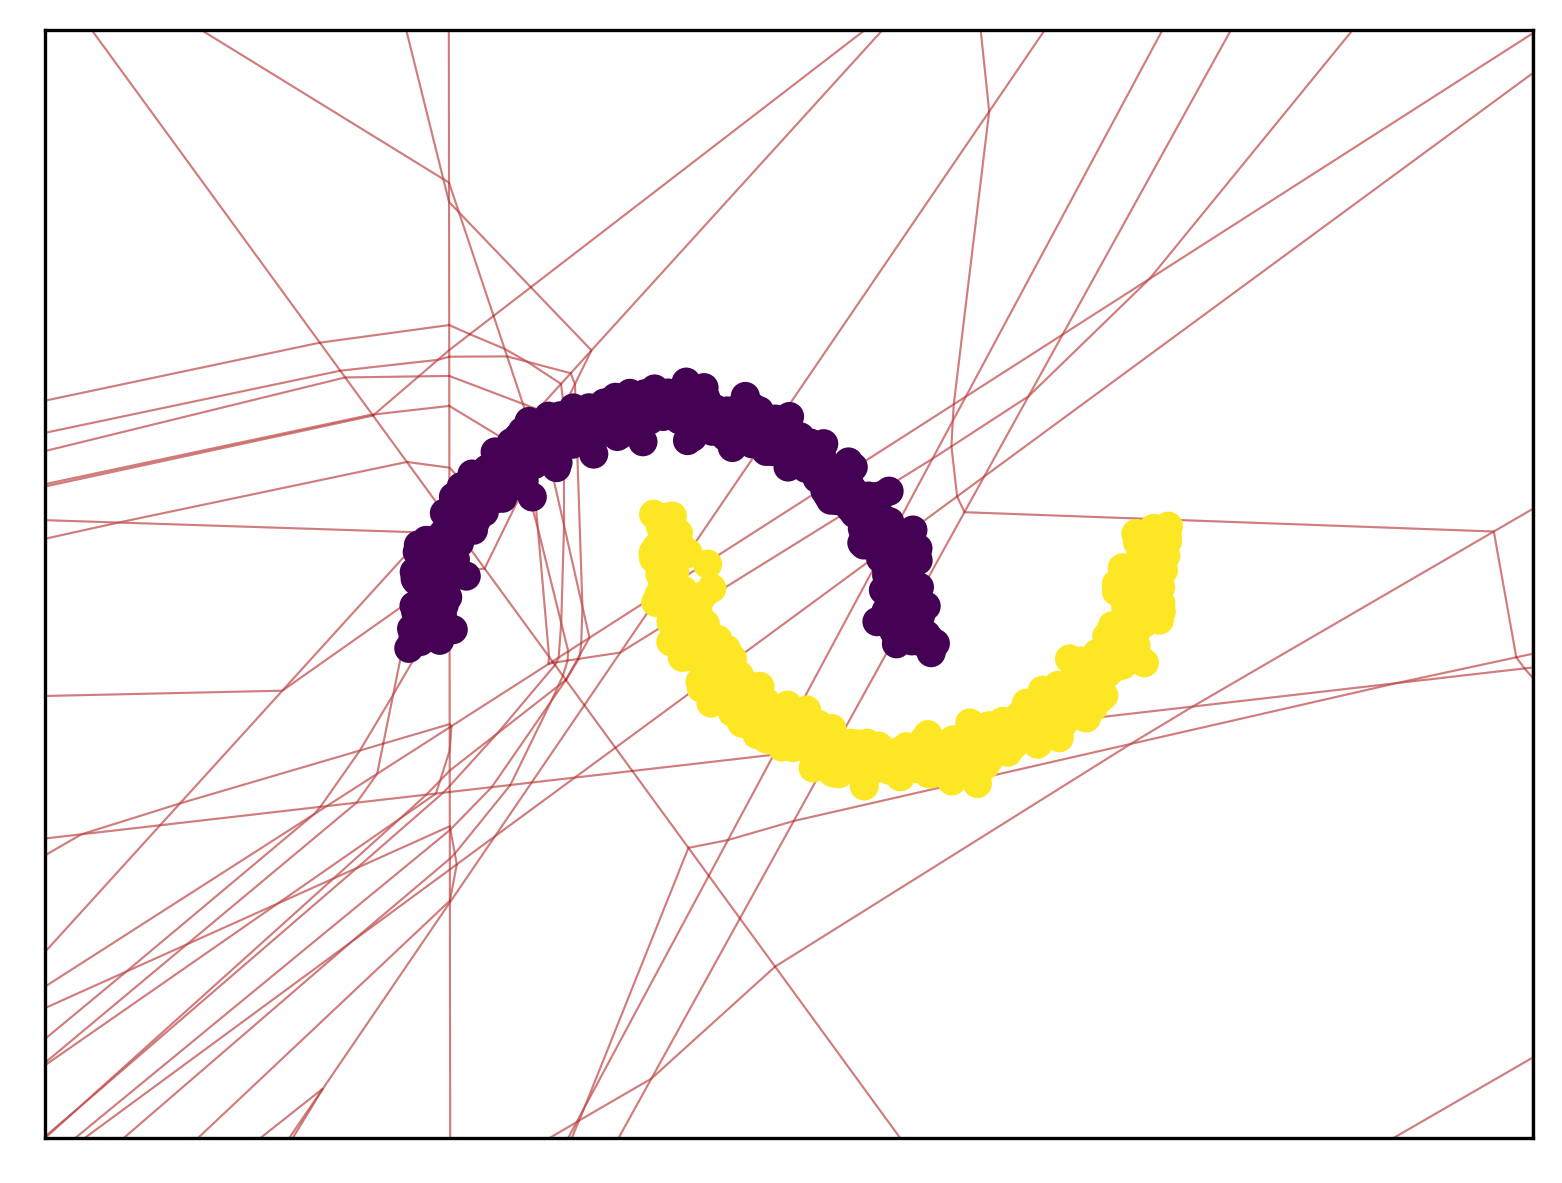

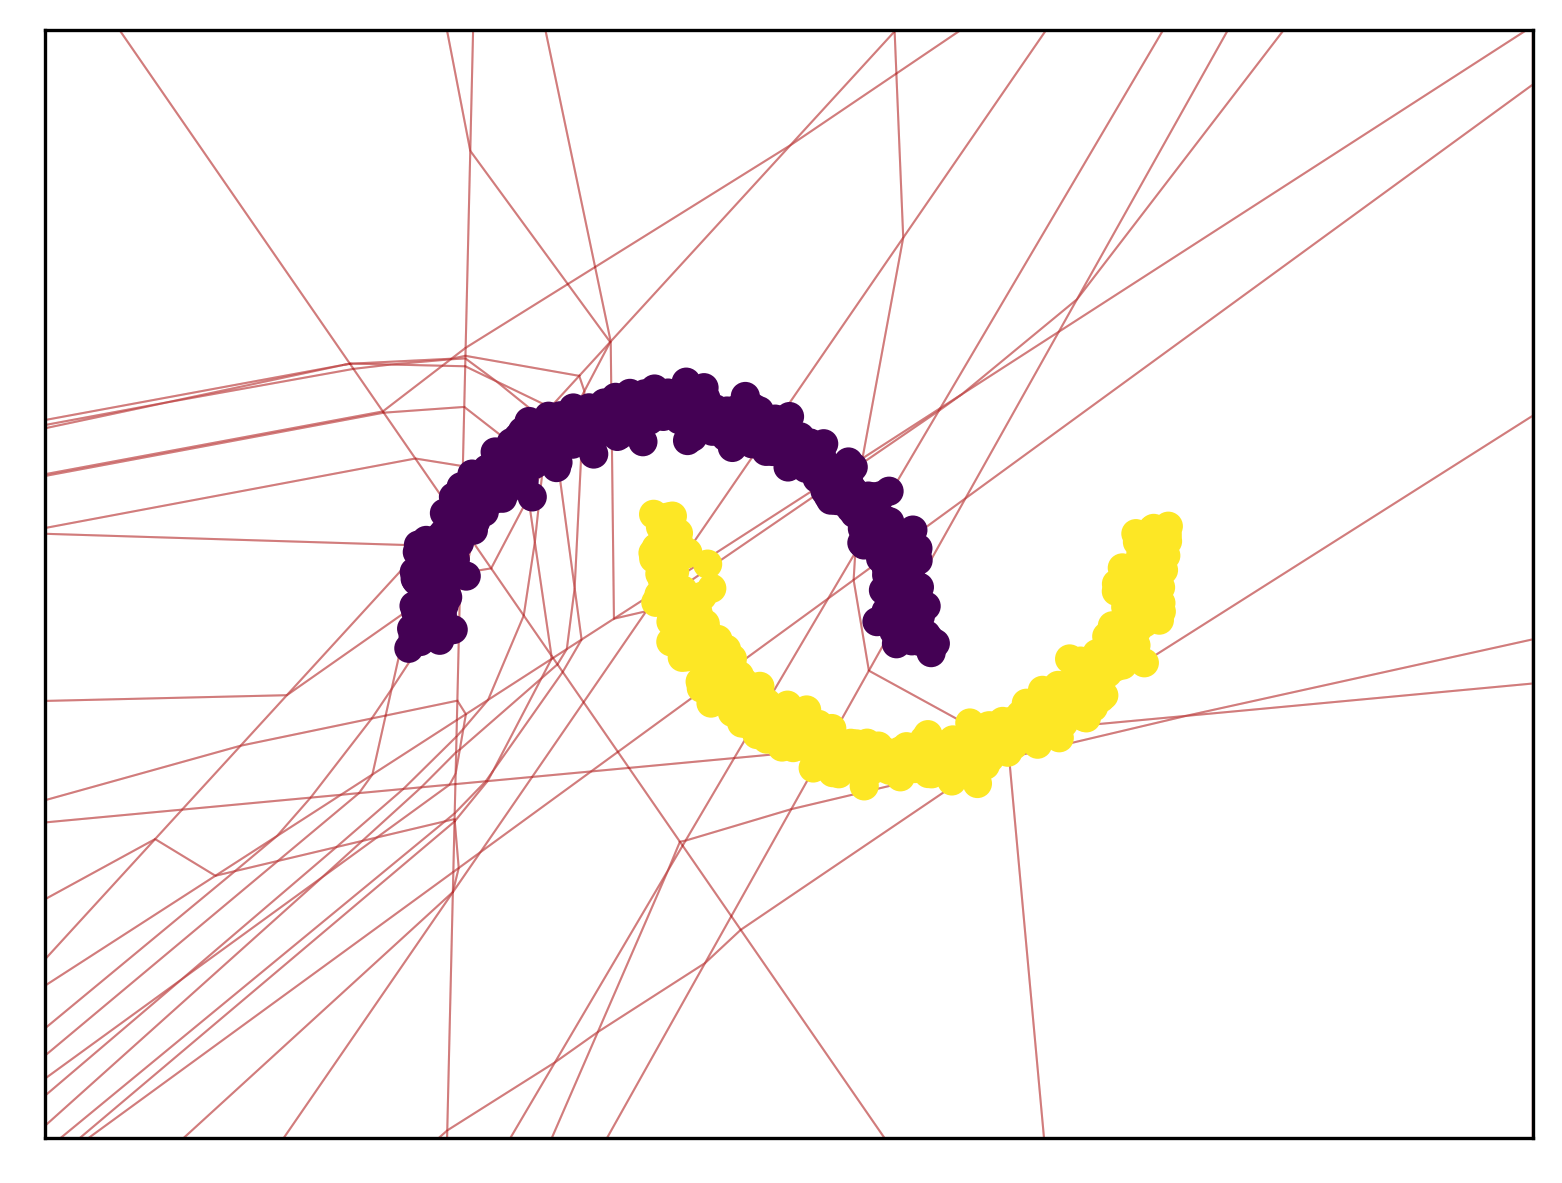

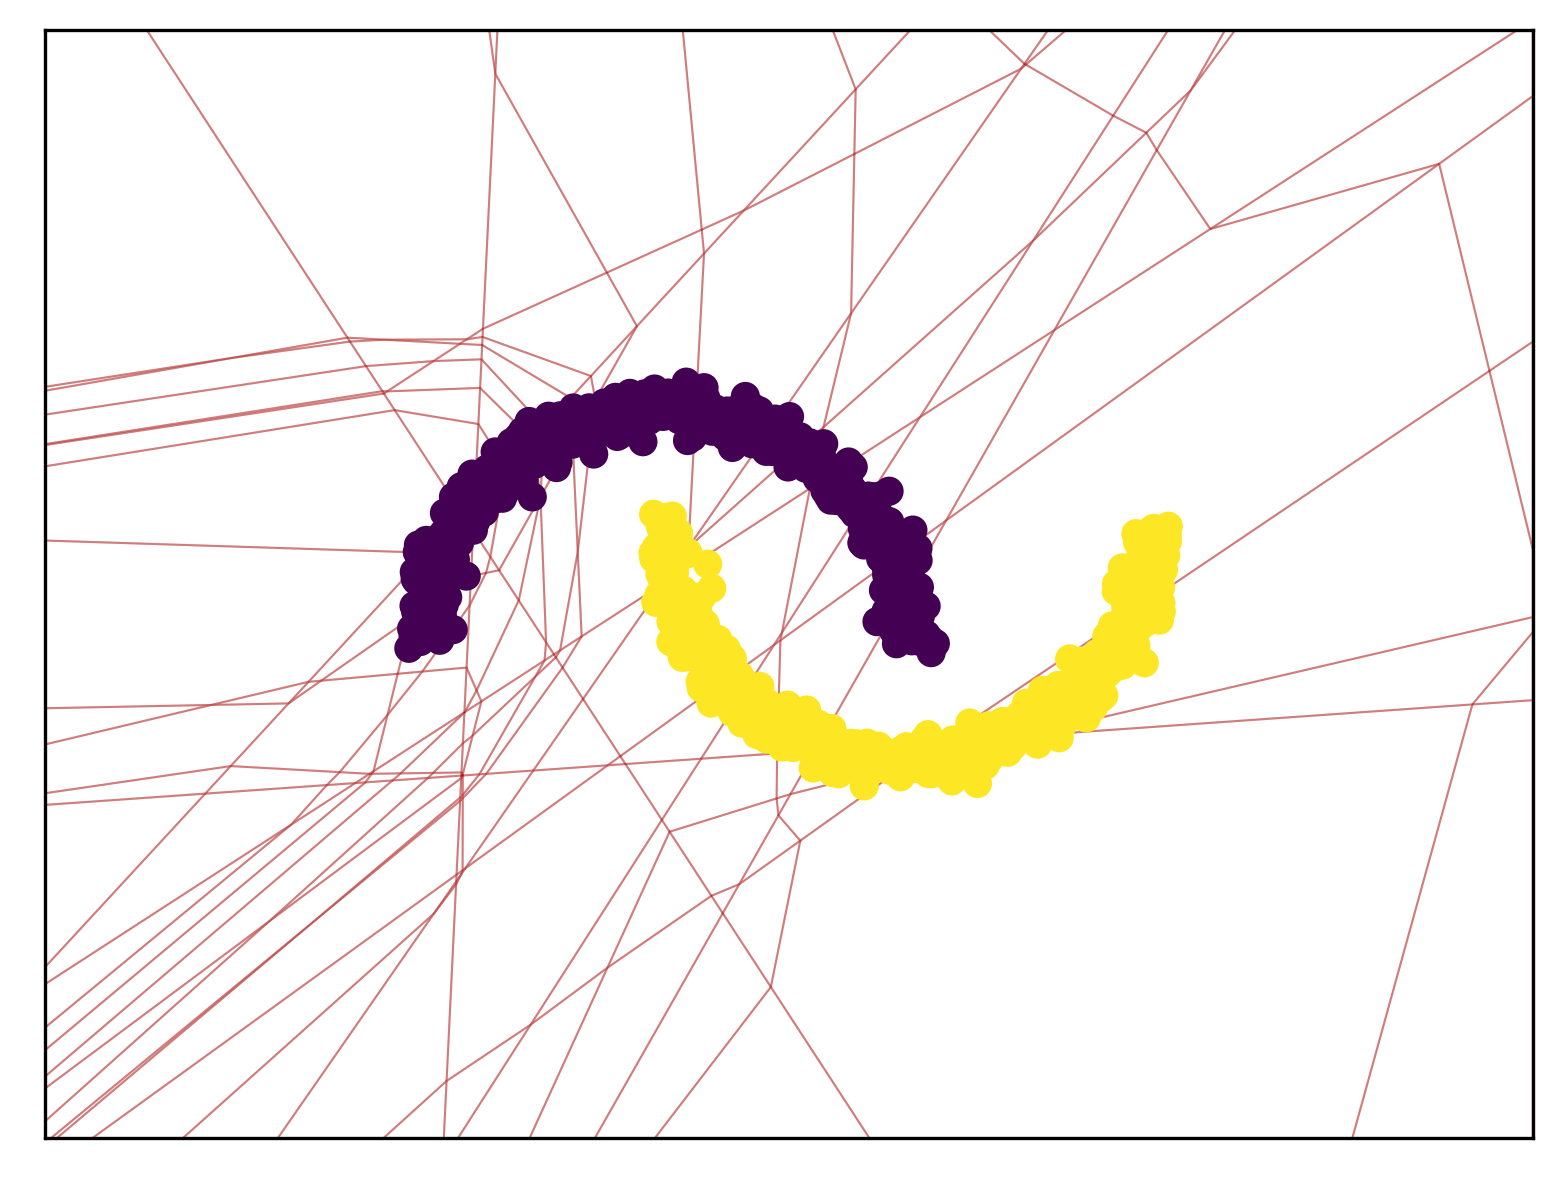

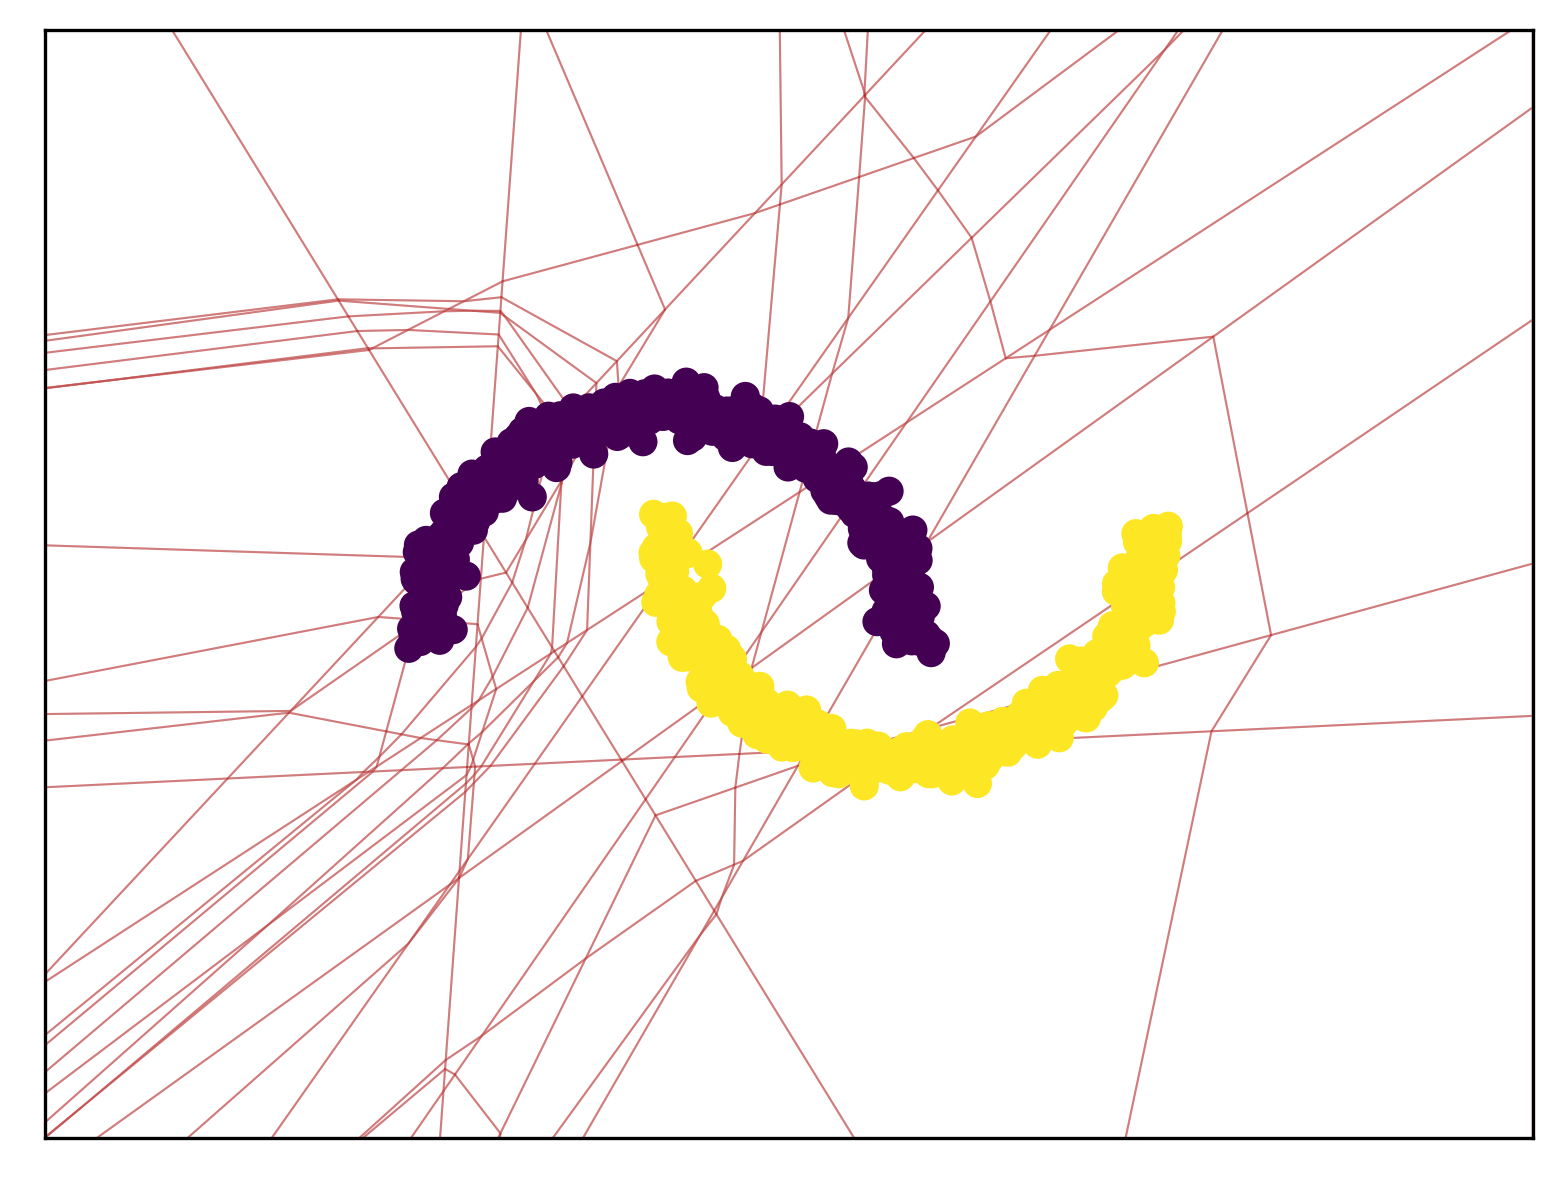

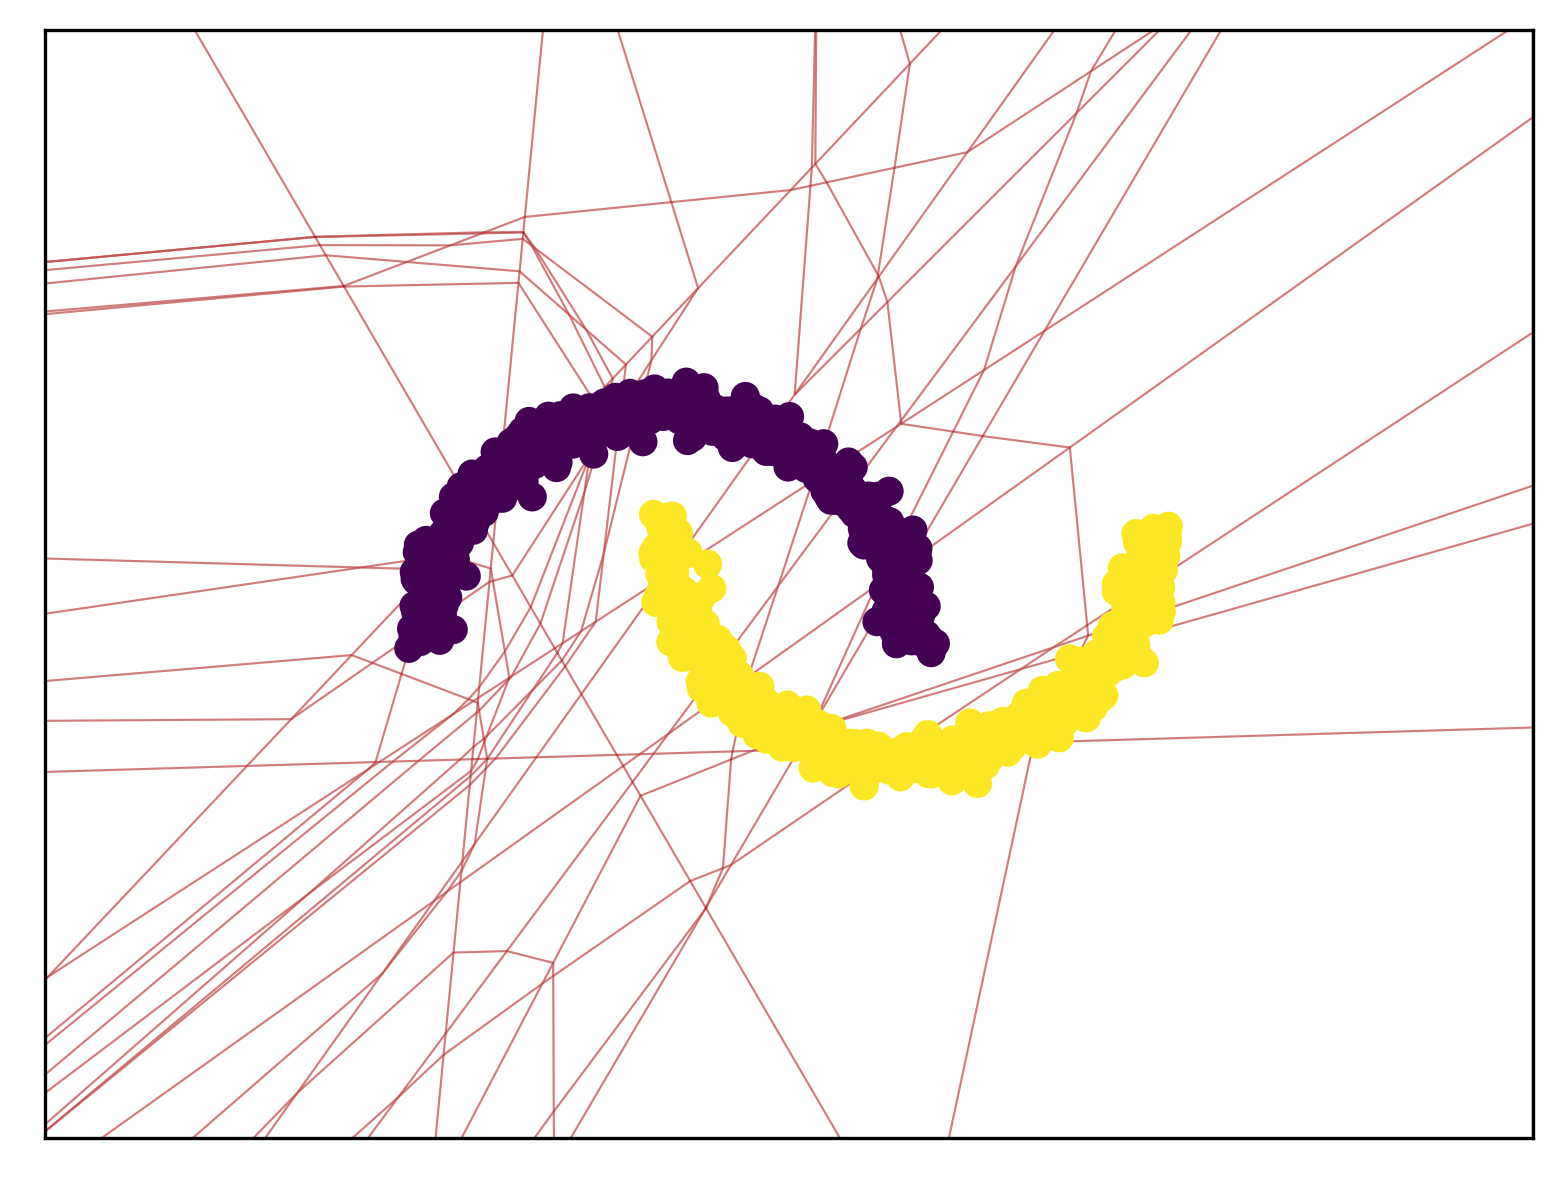

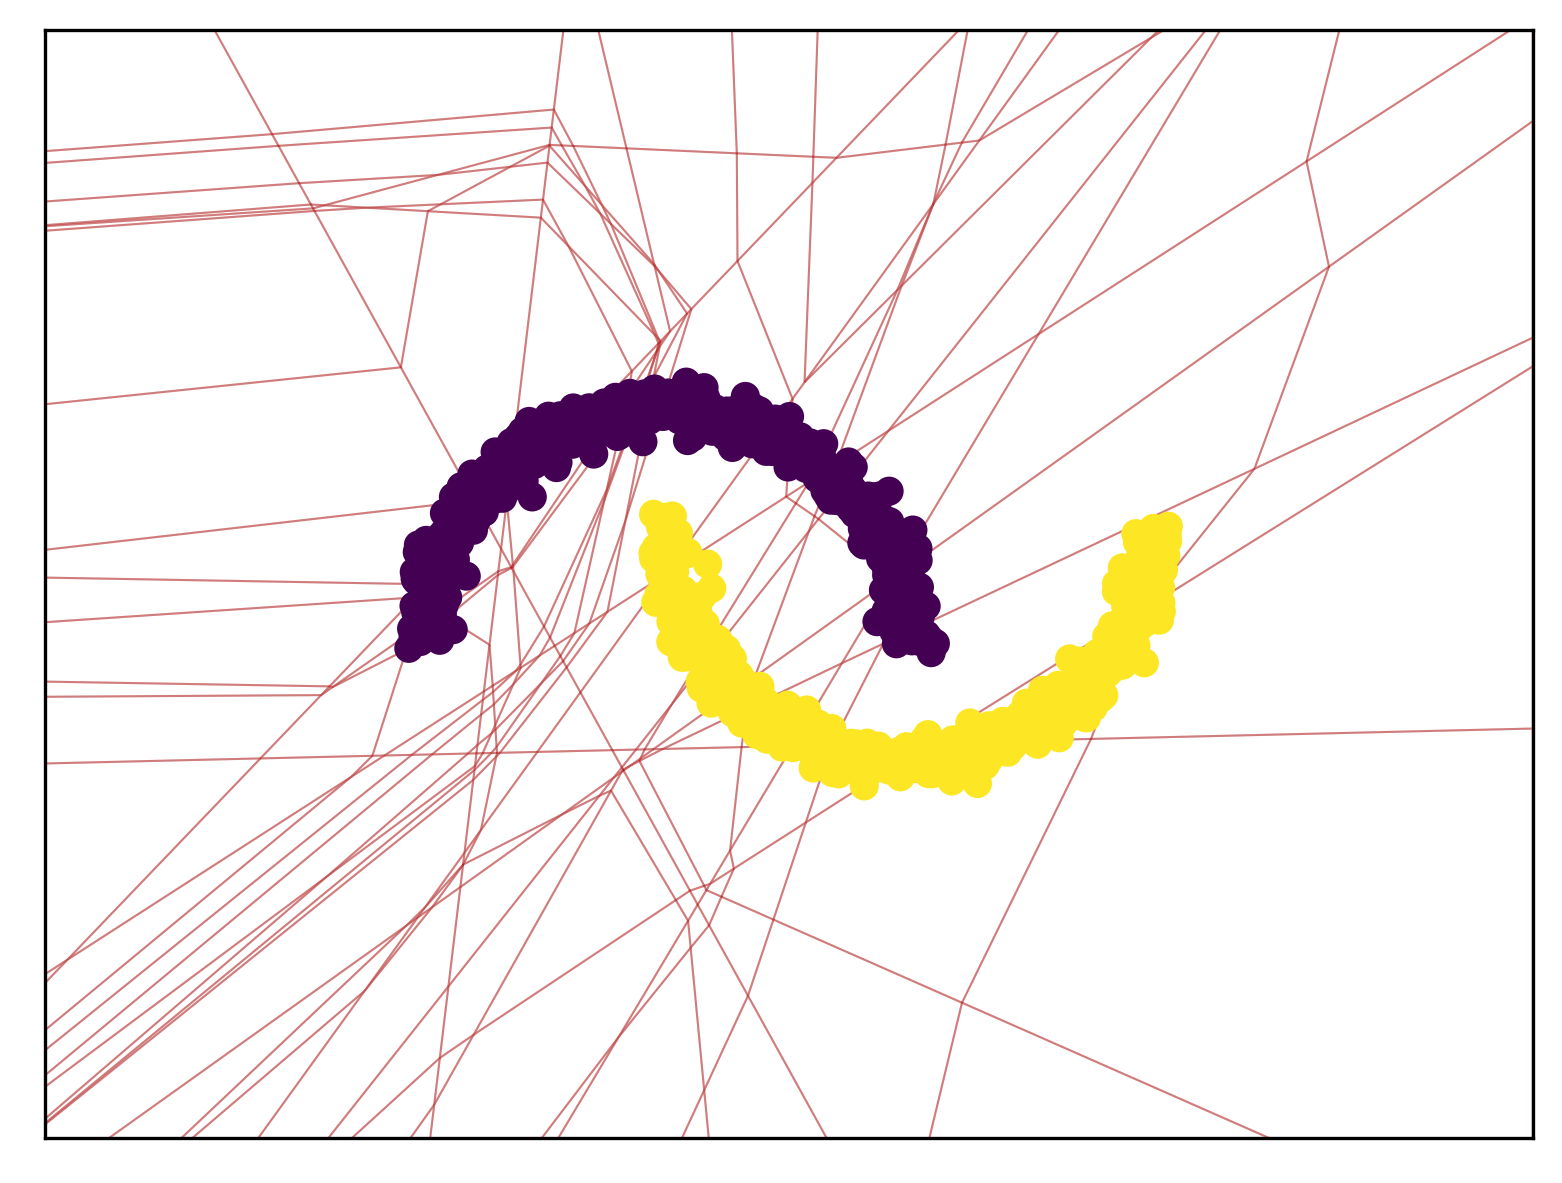

In [6]:
#@title Train and visualize per iteration

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

epochs = 200
device = 'cuda'
model = model.to(device)
model.type(torch.float32)

for epoch in range(1, epochs + 1):
    
    ## train step 

    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(dataloader, 1):
        
        # prep data
        data,target = data[:,:-1],data[:,-1:]
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad() # zero accumulated gradients
        output = model(data)

        # calculate loss and perform backprop
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    
    ## visualize partition 
    
    model.cuda()
    model.eval()
    model.type(torch.float64)

    print('Wrapping model with SplineCam...')
    
    NN = splinecam.wrappers.model_wrapper(
        model,
        input_shape=(2,),
        T = T.double(),
        dtype = torch.float64,
        device = 'cuda'
    )

    ## check .forward() and matmul operation equivalence
    # print('Verifying wrapped model...')
    flag =  NN.verify()
    # print('Model.forward and matmul equivalence check', flag)
    assert flag

    ## specify level set for output neuron, for db visualization
    thresh = 0.5
    NN.layers[-1].Ab[0,-1] = NN.layers[-1].Ab[0,-1] + thresh
    
    
    ## get partitions
    out_cyc,endpoints,Abw = splinecam.compute.get_partitions_with_db(domain,T,NN)
    

    plt.rcParams['figure.dpi'] = 300
    fig,ax = plt.subplots()

    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=5)

    minval,_ = torch.vstack(out_cyc).min(0)
    maxval,_ = torch.vstack(out_cyc).max(0)

    splinecam.plot.plot_partition(out_cyc, xlims=[minval[0],maxval[0]],alpha=0.3,
                             edgecolor='#a70000',color_range=[.3,.8],ax=ax,colors=['none'],
                             ylims=[minval[1],maxval[1]], linewidth=.5)


    ax.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
                dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
                c = dataloader.__dict__['dataset'][:,-1].numpy()
               )

    plt.savefig(f'./animation/{epoch}.png',bbox_inches='tight',pad_inches=0)
    
    model.cuda()
    model.train()
    model.type(torch.float32)
    
    # print loss stats
    print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(dataloader)))

del NN, out_cyc, endpoints

In [7]:
#@title Create Animation

import glob
import imageio
import numpy as np4
import tqdm
# from cv2 import imread ## faster imread
from matplotlib.pyplot import imread

## list files
files = np.asarray(glob.glob('./animation/*.png'))
idx = np.asarray([int(each.split('/')[-1].split('.')[0]) for each in files])
files = files[idx.argsort()]

## export mp4
fps = 30
with imageio.get_writer('test.mp4', mode='I', fps=fps) as writer:
    for each in tqdm.tqdm(files):
#         img = imread(each)[...,::-1] # BRG to RGB for cv2
        img = imread(each) # BRG to RGB
        writer.append_data(img)

  0%|                                                                                                                                                                                                                    | 0/92 [00:00<?, ?it/s]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1502, 1123) to (1504, 1136) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
  1%|██▏                                                                                                                                                                                                         | 1/92 [00:00<01:06,  1.38it/s][swscaler @ 0x6c46f00] Warning: data is not aligned! This can lead to a speed

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 46/92 [00:08<00:10,  4.52it/s]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 69/92 [00:13<00:04,  4.86it/s]Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:16<00:00,  5.41it/s]


In [8]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('test.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)